<a href="https://colab.research.google.com/github/jyotishsanchi/NLP_Learnings/blob/main/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

import tensorflow 
print(tensorflow.__version__)

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SpatialDropout1D, LSTM, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# To encode values
from sklearn.preprocessing import LabelEncoder
# train test split
from sklearn.model_selection import train_test_split


2.3.0


In [3]:
os.chdir('/content/drive/MyDrive')

In [4]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [5]:
df.shape

(200853, 6)

In [6]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [7]:
df = df.drop(['authors', 'date', 'link'], axis=1)

In [8]:
df.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


In [9]:
df.isnull().sum()

category             0
headline             0
short_description    0
dtype: int64

In [10]:
df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [11]:
df['category'].nunique()

41

In [12]:
df['headline'][0]

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV'

In [13]:
df['category'][0]

'CRIME'

In [14]:
df['short_description'][0]

'She left her husband. He killed their children. Just another day in America.'

In [15]:
df[0:1]

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...


In [16]:
import nltk
import re

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
words = nltk.word_tokenize(df['short_description'][0])

In [19]:
bigrams = nltk.bigrams(words)

In [20]:
bigrams

<generator object bigrams at 0x7f7cb5004e08>

In [21]:
for bgram in bigrams:
  print(bgram)

('She', 'left')
('left', 'her')
('her', 'husband')
('husband', '.')
('.', 'He')
('He', 'killed')
('killed', 'their')
('their', 'children')
('children', '.')
('.', 'Just')
('Just', 'another')
('another', 'day')
('day', 'in')
('in', 'America')
('America', '.')


In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [24]:
from nltk.corpus import stopwords

In [25]:
df['headline_length'] = df['headline'].apply(lambda x : len(x))
df['description_length'] = df['short_description'].apply(lambda x : len(x))

In [26]:
df.head()

,category,headline,short_description,headline_length,description_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,64,76
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,75,24
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,47,87
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,69,86
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",71,87


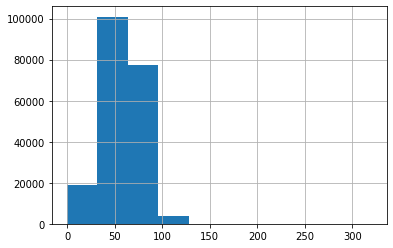

In [27]:
df['headline_length'].hist()

In [28]:
df.describe()

,headline_length,description_length
count,200853.000000,200853.000000
mean,57.940305,114.312686
std,18.913850,82.288156
min,0.000000,0.000000
25%,45.000000,57.000000
50%,59.000000,120.000000
75%,71.000000,133.000000
max,320.000000,1472.000000


In [29]:
df[df['description_length'] == 1472]['short_description']

58142    This week the nation watched as the #NeverTrum...
Name: short_description, dtype: object

In [30]:
stopwords = set(stopwords.words('english'))

In [31]:
def preprocess_text(df, column_name=''):
  # Select only alphabets
  df[column_name] = df[column_name].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

  # Convert text to lowercase
  df[column_name] = df[column_name].apply(lambda x: x.lower())

  # Strip unwanted spaces
  df[column_name] = df[column_name].apply(lambda x: x.strip())

  # Remove stopwords
  df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

  # Replace empty strings with Null
  df[column_name].replace('', np.nan, inplace = True)

  # Drop Null values
  df = df.dropna()

  return df

In [32]:
df = preprocess_text(df, column_name='headline')

In [33]:
df = preprocess_text(df, column_name='short_description')

In [34]:
df.head()

,category,headline,short_description,headline_length,description_length
0,CRIME,2 mass shootings texas last week 1 tv,left husband killed children another day america,64,76
1,ENTERTAINMENT,smith joins diplo nicky jam 2018 world cup off...,course song,75,24
2,ENTERTAINMENT,hugh grant marries first time age 57,actor longtime girlfriend anna eberstein tied ...,47,87
3,ENTERTAINMENT,jim carrey blasts castrato adam schiff democra...,actor gives dems ass kicking fighting hard eno...,69,86
4,ENTERTAINMENT,julianna margulies uses donald trump poop bags...,dietland actress said using bags really cathar...,71,87


In [35]:
df['headline_length'] = df['headline'].apply(lambda x : len(x))
df['description_length'] = df['short_description'].apply(lambda x : len(x))

In [36]:
df.head()

,category,headline,short_description,headline_length,description_length
0,CRIME,2 mass shootings texas last week 1 tv,left husband killed children another day america,37,48
1,ENTERTAINMENT,smith joins diplo nicky jam 2018 world cup off...,course song,56,11
2,ENTERTAINMENT,hugh grant marries first time age 57,actor longtime girlfriend anna eberstein tied ...,36,65
3,ENTERTAINMENT,jim carrey blasts castrato adam schiff democra...,actor gives dems ass kicking fighting hard eno...,60,62
4,ENTERTAINMENT,julianna margulies uses donald trump poop bags...,dietland actress said using bags really cathar...,55,68


In [37]:
df.describe()

,headline_length,description_length
count,180622.000000,180622.000000
mean,45.383591,84.456041
std,16.989724,51.597459
min,1.000000,1.000000
25%,33.000000,50.000000
50%,46.000000,80.000000
75%,57.000000,103.000000
max,274.000000,1002.000000


In [38]:
df.shape

(180622, 5)

In [39]:
max_features = 10000
maxlen = 300
embedding_size = 200
trunc_type = "pre" 
padding_type = "pre"

In [40]:
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

In [41]:
df['category'].value_counts()

24    29485
37    17801
10    13381
30     9634
34     9397
22     8666
13     6213
25     5515
16     5254
3      5073
5      4389
28     4205
17     4189
2      4111
33     3662
35     3651
23     3544
8      3423
38     3075
18     3059
6      2674
20     2268
36     2198
39     2172
32     2075
15     2045
31     1930
26     1849
27     1773
21     1706
29     1528
1      1334
11     1321
40     1242
12     1042
14     1029
7      1019
19     1018
4       918
9       892
0       862
Name: category, dtype: int64

In [42]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['short_description']))
X = tokenizer.texts_to_sequences(df['short_description'])

print("Number of Samples:", len(X))       
print(X[0])

Number of Samples: 180622
[256, 379, 561, 50, 83, 9, 101]


In [43]:
X = pad_sequences(X, maxlen = maxlen, padding = padding_type, truncating = trunc_type)     
y = tensorflow.keras.utils.to_categorical(df['category'])

print("Number of Labels: ", len(y))     
print(y[0])

Number of Labels:  180622
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [44]:
#tokenizer.word_index

In [45]:
X.shape

(180622, 300)

In [46]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [47]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

73658


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, stratify=y, test_size=0.2)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(144497, 300)
(36125, 300)
(144497, 41)
(36125, 41)


In [50]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(41, activation="softmax"))

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          14731600  
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 256)          336896    
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               39322112  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [52]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.01)
mc = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [54]:
batch_size = 100
epochs = 20

model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                          validation_data=(X_test, y_test),
                          callbacks=[es, mc])

Epoch 1/20
1445/1445 [==============================] - ETA: 0s - loss: 2.7810 - accuracy: 0.3082
Epoch 00001: val_accuracy improved from -inf to 0.40426, saving model to best_model1.h5
1445/1445 [==============================] - 320s 222ms/step - loss: 2.7810 - accuracy: 0.3082 - val_loss: 2.3601 - val_accuracy: 0.4043
Epoch 2/20
1445/1445 [==============================] - ETA: 0s - loss: 2.3051 - accuracy: 0.4214
Epoch 00002: val_accuracy improved from 0.40426 to 0.43668, saving model to best_model1.h5
1445/1445 [==============================] - 317s 220ms/step - loss: 2.3051 - accuracy: 0.4214 - val_loss: 2.2026 - val_accuracy: 0.4367
Epoch 3/20
1445/1445 [==============================] - ETA: 0s - loss: 2.1170 - accuracy: 0.4598
Epoch 00003: val_accuracy improved from 0.43668 to 0.44958, saving model to best_model1.h5
1445/1445 [==============================] - 318s 220ms/step - loss: 2.1170 - accuracy: 0.4598 - val_loss: 2.1567 - val_accuracy: 0.4496
Epoch 4/20
1445/1445 [===

In [55]:
# load the saved model
saved_model = load_model('best_model1.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(X_train,  y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.514, Test: 0.450


Text(0.5, 1.0, 'Training and validation loss')

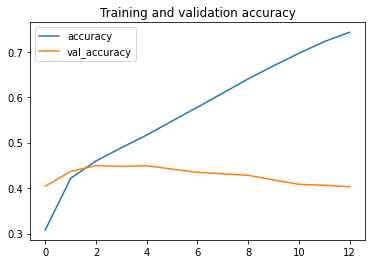

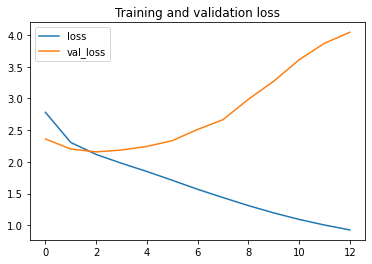

In [56]:
evaluation = pd.DataFrame(model_history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
plt.title('Training and validation accuracy')
evaluation[['loss', 'val_loss']].plot()
plt.title('Training and validation loss')

### Pretrained weights

In [57]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [58]:
model2 = Sequential()
model2.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length=maxlen))
model2.add(Bidirectional(LSTM(128, return_sequences = True)))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation= 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(41, activation="softmax"))

In [59]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.01)
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [61]:
batch_size = 100
epochs = 20

model2_history = model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                          validation_data=(X_test, y_test),
                          callbacks=[es, mc])

Epoch 1/20
1445/1445 [==============================] - ETA: 0s - loss: 2.4709 - accuracy: 0.3939
Epoch 00001: val_accuracy improved from -inf to 0.45451, saving model to best_model2.h5
1445/1445 [==============================] - 328s 227ms/step - loss: 2.4709 - accuracy: 0.3939 - val_loss: 2.0953 - val_accuracy: 0.4545
Epoch 2/20
1445/1445 [==============================] - ETA: 0s - loss: 2.1151 - accuracy: 0.4681
Epoch 00002: val_accuracy improved from 0.45451 to 0.47471, saving model to best_model2.h5
1445/1445 [==============================] - 332s 230ms/step - loss: 2.1151 - accuracy: 0.4681 - val_loss: 2.0160 - val_accuracy: 0.4747
Epoch 3/20
1445/1445 [==============================] - ETA: 0s - loss: 1.9693 - accuracy: 0.4969
Epoch 00003: val_accuracy improved from 0.47471 to 0.48185, saving model to best_model2.h5
1445/1445 [==============================] - 334s 231ms/step - loss: 1.9693 - accuracy: 0.4969 - val_loss: 2.0142 - val_accuracy: 0.4819
Epoch 4/20
1445/1445 [===

In [62]:
# load the saved model
saved_model = load_model('best_model2.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(X_train,  y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.545, Test: 0.482


Text(0.5, 1.0, 'Training and validation loss')

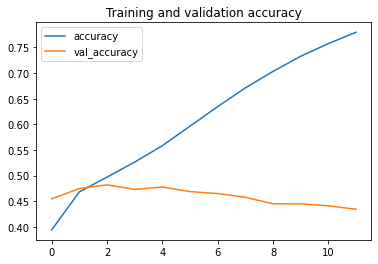

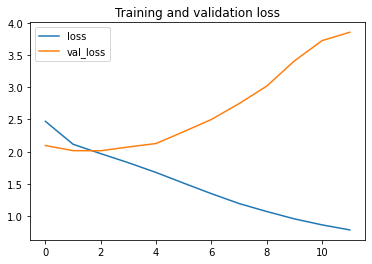

In [63]:
evaluation = pd.DataFrame(model2_history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
plt.title('Training and validation accuracy')
evaluation[['loss', 'val_loss']].plot()
plt.title('Training and validation loss')

In [70]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))
print(np.argmax(model.predict(padded), axis = -1))


[[9.2868031e-06 1.7885670e-02 4.4583857e-02 3.3305127e-03 8.7293878e-04
  6.4740747e-02 4.3331613e-03 2.5641712e-05 6.6023182e-05 4.5876768e-05
  4.2517665e-01 9.4478046e-06 3.4882919e-06 9.3514856e-04 5.6538982e-03
  1.0239761e-03 6.4702416e-03 1.1784084e-03 1.7185112e-03 1.6083021e-02
  1.7550396e-02 7.3890260e-06 1.7024062e-04 9.3622627e-03 1.4542910e-01
  5.3367678e-02 3.9879456e-03 7.7976298e-04 8.5539192e-02 6.1347936e-03
  4.4974377e-03 1.6090153e-03 3.1116763e-03 3.0357039e-03 1.9679542e-03
  1.4361902e-04 3.6993396e-02 1.2328509e-04 2.9750057e-02 2.2830083e-03
  9.5956893e-06]
 [2.5954114e-07 9.2950190e-04 7.7013271e-03 4.2489269e-06 2.0236867e-07
  1.5672369e-02 1.1991537e-07 5.5059900e-07 9.2923369e-07 1.9500117e-09
  9.6024716e-01 2.5067028e-09 2.4432250e-08 2.6782830e-06 7.6072058e-05
  4.0844427e-08 2.1138374e-05 2.4927002e-05 1.9865342e-06 5.3998682e-04
  1.7809531e-05 8.5735818e-09 6.3838174e-06 7.4913783e-04 3.0358606e-05
  1.0358313e-02 6.1704723e-06 1.0559282e-06 4.3

### **Testing**

In [68]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
print(model2.predict(padded))
print(np.argmax(model2.predict(padded), axis = -1))

[[2.8547682e-04 3.8038522e-02 8.6457305e-02 3.5039838e-03 1.0289797e-03
  4.7120128e-02 6.2446292e-03 3.6823220e-04 1.6863273e-03 9.7494521e-05
  4.1782624e-01 2.1998741e-04 2.6281356e-04 2.2721279e-03 1.6682586e-02
  1.1382068e-03 7.4414713e-03 5.9592463e-03 3.4564119e-03 2.5946958e-02
  1.1005123e-02 1.4132478e-04 3.2955988e-03 3.3100493e-02 2.5048345e-02
  8.4795818e-02 9.3566952e-03 2.1588034e-03 3.7103713e-02 1.1587601e-02
  1.5484780e-02 1.6625003e-03 5.2497964e-03 4.0596924e-03 1.0910969e-02
  1.5665615e-03 2.1843476e-02 7.3408370e-04 5.2099559e-02 2.7330450e-03
  2.4836800e-05]
 [1.5151021e-07 3.9245342e-03 7.2599729e-03 9.6582156e-04 2.1194272e-05
  1.7139122e-01 4.9397694e-03 6.4811246e-07 4.3539876e-06 6.4436097e-07
  1.4516281e-01 3.1953536e-05 2.0465792e-07 1.2135697e-02 6.5683968e-02
  7.1667307e-03 1.4973309e-02 9.7898012e-03 3.7260319e-04 1.5502253e-03
  2.3561581e-03 1.5930150e-06 1.4484498e-04 2.7812995e-02 4.4218089e-02
  9.1288611e-03 1.2257147e-03 9.9948021e-03 4.7

In [71]:
sentence = ["Rojer federer is into the wimbledon finals", 
            "NASA to launch two more satellites this year"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))
print(np.argmax(model.predict(padded), axis = -1))

[[4.2978750e-06 2.9260605e-03 2.5786096e-02 8.0612605e-04 2.4652557e-04
  1.2612604e-02 6.2643546e-03 4.6339314e-06 7.2819562e-06 2.2253329e-05
  5.9166253e-02 4.7921940e-06 2.9148276e-07 2.2022323e-05 9.7398479e-03
  5.9379160e-04 1.5477169e-03 3.4442583e-05 9.1772777e-04 3.4228805e-03
  2.8801055e-03 3.2075766e-07 1.3497038e-04 3.5087806e-03 1.4125418e-02
  1.9858208e-02 1.8044539e-03 6.9291028e-04 7.9149342e-01 5.8116457e-05
  1.3482178e-04 3.1294720e-05 4.3017074e-04 2.8185561e-04 1.4688999e-03
  1.7314327e-05 3.3630855e-02 2.1694643e-04 4.8123617e-03 2.8639252e-04
  2.3994071e-06]
 [1.1613707e-07 1.3365359e-04 1.5596352e-03 2.8815240e-01 5.5898988e-04
  1.1411916e-01 4.3719614e-04 4.6065014e-07 1.6668496e-06 2.6708765e-05
  3.4879795e-03 6.2192310e-05 5.0661760e-07 8.1427384e-04 6.8640839e-03
  1.3051587e-02 1.2497400e-01 1.2712018e-03 2.7077325e-02 1.7842212e-03
  1.0409479e-02 3.1140360e-05 3.7828613e-05 2.5923168e-03 2.2751343e-01
  1.3783311e-03 1.0434666e-03 1.7365023e-02 3.2

In [72]:
sentence = ["Rojer federer is into the wimbledon finals", 
            "NASA to launch two more satellites this year"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
print(model2.predict(padded))
print(np.argmax(model2.predict(padded), axis = -1))

[[3.89450037e-08 1.97774061e-04 8.41041282e-03 8.15760868e-04
  1.19738528e-04 5.51654352e-03 1.99023765e-04 1.10700057e-07
  5.71020735e-07 1.23306435e-07 8.95304698e-03 8.57764988e-08
  3.93475190e-08 1.80230199e-05 1.32165995e-04 1.24220687e-05
  8.54932878e-04 3.76069656e-05 1.10328394e-04 6.55526295e-04
  1.06053788e-03 3.56494553e-07 4.10556595e-06 1.41717843e-04
  1.77526474e-02 2.58478755e-03 1.57518254e-04 2.33035258e-04
  9.48143423e-01 2.62914000e-05 1.65380101e-04 3.58625266e-06
  1.96039313e-04 4.28059138e-05 1.33677124e-04 2.03283480e-06
  1.40676205e-03 1.79316085e-05 1.86148286e-03 3.15385514e-05
  2.72635514e-08]
 [4.80861266e-18 3.76227827e-10 3.56522784e-10 8.05756645e-05
  1.88929719e-10 1.35560725e-07 3.39485329e-10 4.94468778e-13
  1.03834462e-13 1.60772437e-11 5.19606788e-11 1.45821593e-06
  2.64967152e-16 1.44335550e-11 4.31290985e-08 2.75212486e-04
  1.48668609e-04 1.54578555e-11 2.70178189e-05 6.91573838e-12
  2.27466307e-06 5.17284653e-12 8.47412002e-11 3.803

In [73]:
sentence = ["today sachin played really well but others didnt support him well", 
            "need to work on know issues and get ready for next match"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
# preict the label
print(model.predict(padded))
print(np.argmax(model.predict(padded), axis = -1))

[[9.19657992e-04 2.54321620e-02 5.72277680e-02 4.86927712e-03
  1.32369075e-03 5.08332141e-02 1.31492864e-03 1.30181236e-03
  2.47328402e-03 1.12467998e-04 5.12511075e-01 1.12882881e-04
  4.58873110e-04 6.46752072e-04 6.03824575e-03 3.56312026e-04
  5.76499104e-03 1.72338064e-03 3.65387229e-03 1.45243518e-02
  6.71004783e-03 2.56976491e-04 3.36297136e-03 1.16168205e-02
  1.21417409e-02 1.35001138e-01 6.54361723e-03 1.20788754e-03
  3.30989286e-02 3.90199362e-03 1.05579961e-02 3.92487476e-04
  1.80331909e-03 4.05678496e-04 5.94896963e-03 2.96897534e-03
  9.73537657e-03 3.46501032e-03 5.88249080e-02 4.22258279e-04
  3.38515310e-05]
 [8.31508834e-04 1.71767529e-02 3.19475718e-02 2.83994712e-02
  5.39120194e-03 7.96848908e-02 1.44779366e-02 1.43090100e-03
  2.55333702e-03 1.72410579e-03 1.14764497e-01 1.87641464e-03
  7.45520054e-04 1.50913056e-02 1.44040491e-02 1.15814973e-02
  2.65661292e-02 1.05237374e-02 1.77766196e-02 2.08837762e-02
  2.88255569e-02 1.54002209e-03 6.68210443e-03 2.214

In [74]:
sentence = ["today sachin played really well but others didnt support him well", 
            "need to work on know issues and get ready for next match"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
# preict the label
print(model2.predict(padded))
print(np.argmax(model2.predict(padded), axis = -1))

[[0.00213995 0.00996457 0.03084903 0.00949936 0.00402413 0.04234464
  0.01332505 0.00287133 0.02505419 0.00480694 0.05750351 0.00761113
  0.01016065 0.00869536 0.05352272 0.00717532 0.024057   0.01079843
  0.02534252 0.00891678 0.00462233 0.00663449 0.13431385 0.16616182
  0.02975897 0.07452665 0.02352703 0.00858729 0.02232074 0.00445277
  0.0150567  0.00400775 0.00951518 0.00583386 0.0390139  0.01512346
  0.02023813 0.02071586 0.03244879 0.00399999 0.00047774]
 [0.01566639 0.01944919 0.02397567 0.02765877 0.00690377 0.04408582
  0.00703773 0.02922743 0.01874274 0.00412372 0.04524993 0.01661833
  0.01144615 0.05019616 0.02009026 0.00842471 0.0205242  0.09727342
  0.02216196 0.00657297 0.00871582 0.01914426 0.03196461 0.0177695
  0.02418148 0.02820581 0.01415633 0.01358464 0.01061092 0.02931739
  0.07559256 0.01427114 0.02556559 0.00657887 0.06779664 0.0319558
  0.02169385 0.03506409 0.02176435 0.00394593 0.00269106]]
[23 17]


In [77]:
sentence = ["A. R. Rahman, is an Indian composer."]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding_type, truncating=trunc_type)

# preict the label
# preict the label
print(model2.predict(padded))
print(np.argmax(model2.predict(padded), axis = -1))
# preict the label
print(model.predict(padded))
print(np.argmax(model.predict(padded), axis = -1))

[[4.3201766e-05 1.6052879e-02 2.3358963e-02 4.9121100e-03 6.9506315e-04
  9.9317975e-02 5.7430719e-03 7.3413648e-05 1.2952981e-04 3.3652374e-05
  2.4471560e-01 6.7795459e-05 1.8895082e-05 3.0732507e-02 2.1139510e-02
  2.6044224e-03 1.9312993e-02 2.0939330e-02 1.7532470e-03 9.2488043e-03
  7.9606492e-03 4.8233720e-05 5.5739278e-04 3.2558855e-02 8.8542618e-02
  2.1744069e-02 3.7590568e-03 6.8227099e-03 1.0510191e-01 4.5238648e-02
  2.2404719e-02 2.7458569e-02 1.1597000e-02 5.1035974e-03 1.1953292e-02
  4.3653796e-04 8.7281682e-02 2.9345026e-04 1.7863572e-02 2.3595802e-03
  2.0867928e-05]]
[10]
[[8.7991630e-08 6.5511060e-03 1.6532594e-02 8.7482086e-04 8.7356821e-05
  8.1886820e-02 6.8720328e-03 4.6302605e-07 1.2970563e-06 5.6360855e-06
  1.8510284e-01 2.9527159e-06 3.6054917e-08 6.2693735e-03 4.8123255e-02
  3.2775654e-03 1.7978771e-02 5.1139607e-03 4.3974788e-04 4.6813888e-03
  4.3985024e-03 1.2498504e-07 3.4825905e-05 5.7776302e-02 1.0195652e-01
  1.0859169e-02 1.1089129e-03 4.4144480e-